# Author Details:
- **Name:** Anmol Gupta
- **Email:** getanmol.gupta@gmail.com
- **LinkedIn:** www.linkedin.com/in/anmol-gupta-9a905a228

**This Notebook is prepared for practice purpose please hit the upvote if you like the work**

## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  Importing Required Libraries </div> 

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras 
import keras_tuner

2024-03-16 14:39:29.862181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 14:39:29.862276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 14:39:30.010810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  Loading Data </div> 

In [3]:
random_sample = '/kaggle/input/urbansound8k/fold7/157940-9-0-4.wav'
metadata = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
audio_dataset_path = '/kaggle/input/urbansound8k'

## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  Checking Random Data </div> 

In [4]:
plt.figure(figsize=(14,5 ))
ipd.Audio(random_sample)

<Figure size 1400x500 with 0 Axes>

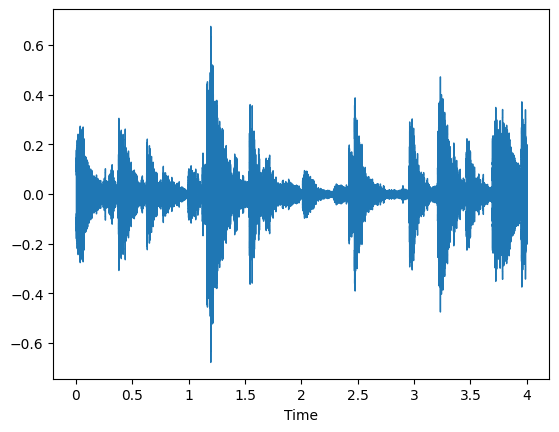

In [5]:
#Sample rate is the number of samples per second that are taken of a waveform to create a discete digital signal.
data,sample_rate = librosa.load(random_sample)
librosa.display.waveshow(data,sr = sample_rate)

In [6]:
# data is already normalized
data

array([0.11713073, 0.17861189, 0.15188843, ..., 0.09620722, 0.08403455,
       0.07895743], dtype=float32)

In [7]:
sample_rate

22050

In [8]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(random_sample)

In [9]:
wave_sample_rate

48000

#### note 
- the difference in the sound rate is due to the fact that librosa try to normalize the wav and give us mono audio

In [10]:
wave_audio

array([[409906944, 314636800],
       [399559168, 317931264],
       [388396288, 322412032],
       ...,
       [135345408, 207311872],
       [120923136, 193362432],
       [109352448, 186647552]], dtype=int32)

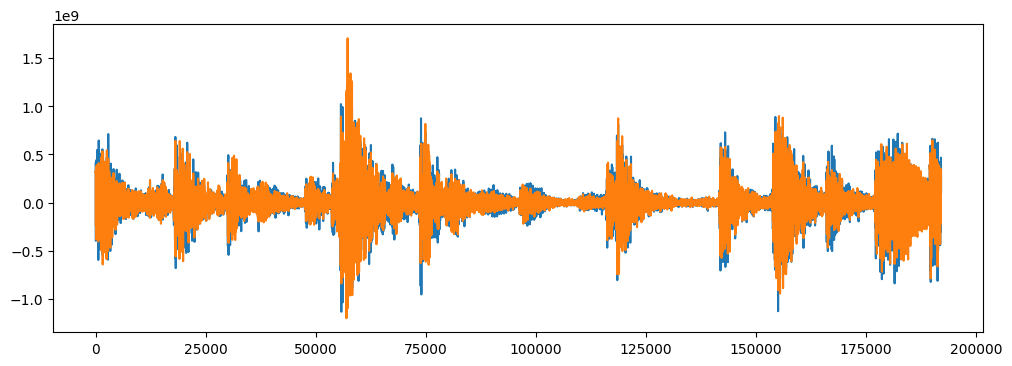

In [11]:
plt.figure(figsize=(12,4))
plt.plot(wave_audio)

## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  Descriptive analysis  </div> 

In [12]:
metadata['slice_file_name'][0]

'100032-3-0-0.wav'

In [13]:
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


- slice_file_name: The name of the slice file.
- fsID: the Freesound ID of the recording from which this excerpt (slice) is taken
- start: The start time of the slice in the original Freesound recording
- end: The end time of slice in the original Freesound recording
- salience: Salience of the slice.
- fold: The fold number (1-10) to which this file has been allocated.
- classID: A numeric identifier of the sound class:
- 0 = air_conditioner
- 1 = car_horn
- 2 = children_playing
- 3 = dog_bark
- 4 = drilling
- 5 = engine_idling
- 6 = gun_shot
- 7 = jackhammer
- 8 = siren
- 9 = street_music

- class: The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer,siren, street_music.

#### 1. Computing Dimension of Dataset

In [14]:
print('dataset shape: ', metadata.shape)

dataset shape:  (8732, 8)


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman ; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;"> Exploratory Data Analysis (EDA) </div> 

#### 1. Visualizing the Distribution of each Fault_Type class

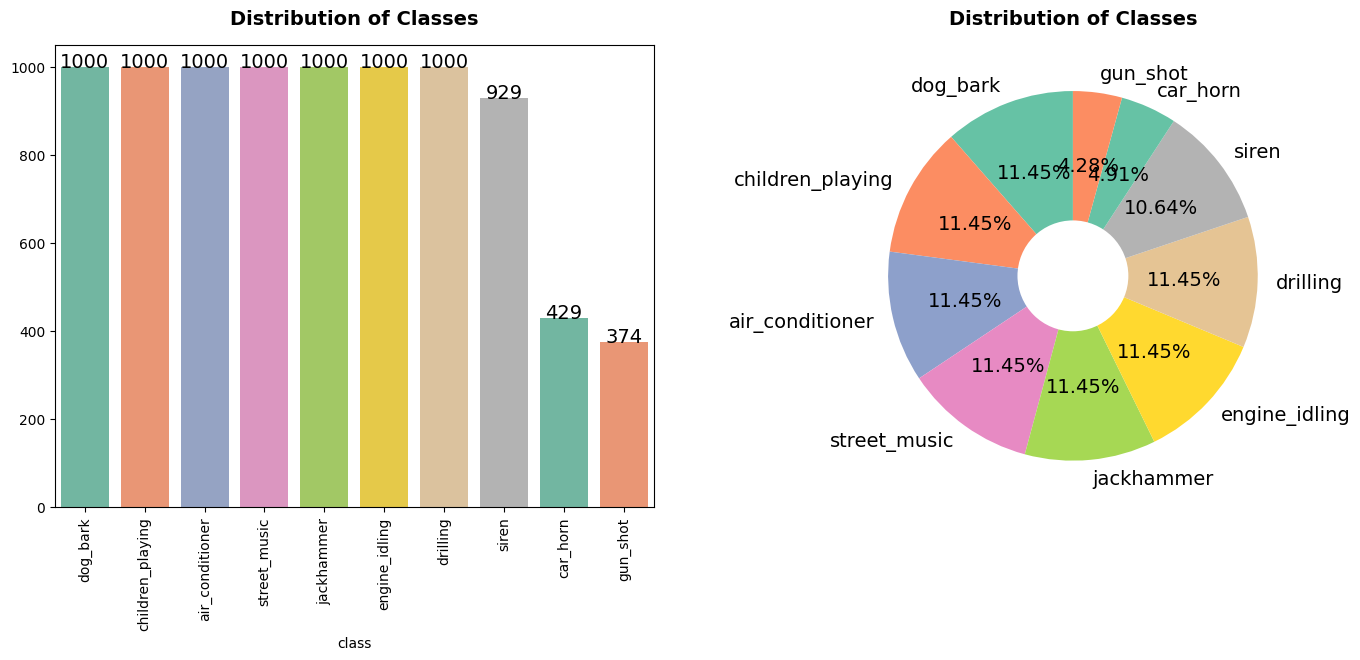

In [15]:
# Visualization to show distribution of Fault_Type classes
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
counts = metadata["class"].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette='Set2')
plt.title("Distribution of Classes", fontweight="black", size=14, pad=15)
for i, v in enumerate(counts.values):
    plt.text(i, v, v, ha="center", fontsize=14)
plt.xticks(rotation=90)
# Visualization to show distribution of Fault_Type classes in percentage
plt.subplot(1, 2, 2)
colors = sns.color_palette('Set2', len(counts))
plt.pie(counts, labels=counts.index, autopct="%.2f%%", textprops={"size": 14},
        colors=colors, startangle=90)
center_circle = plt.Circle((0, 0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Distribution of Classes", fontweight="black", size=14, pad=15)
plt.show()


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman ; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;"> Extract Features </div> 

Here we will using Mel-Frequency  Cepstral coefficients(MFCC) from the audio samples. the MFCC summarises the frequency distribution across the window size, so it is posiible to analyse both the frequency and time characteristics of the sound. These audio representation will allow us to identify features for classification

In [16]:
#lets apply on any single random wav file first for our understanding
mfccs = librosa.feature.mfcc(y=data, sr = sample_rate, n_mfcc=40)
print(mfccs.shape)
print(mfccs)

(40, 173)
[[-184.0352    -187.40276   -193.20993   ... -198.44003   -174.2328
  -183.6397   ]
 [ 146.16049    169.58658    176.89969   ...  177.93115    176.63483
   167.84184  ]
 [   1.1239209   -6.7309923  -10.326082  ...    8.095651    -4.3727756
     4.633686 ]
 ...
 [  -6.4328566   -7.6201305   -3.7162256 ...   -9.615774    -4.319595
    -1.7421865]
 [ -14.677769   -14.992378    -9.961443  ...   -6.4062366   -6.8715954
    -4.311482 ]
 [ -10.235505    -9.442057    -6.2701902 ...   -2.6080418   -4.5660877
    -1.9511013]]


In [17]:
def feature_extraction(file):
    audio, sample_rate = librosa.load(file)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=64)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [18]:
# Iterating through each row
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    # Constructing file path
    audioFile = os.path.join(audio_dataset_path, 'fold' + str(row['fold']), row['slice_file_name'])
    final_class_labels = row["class"]
    data = feature_extraction(audioFile)
    extracted_features.append([data,final_class_labels])

8732it [07:47, 18.68it/s]


In [19]:
extracted_features_df = pd.DataFrame(extracted_features,columns =['features','class'] )
extracted_features_df.head(10)

,features,class
0,"[-211.93698, 62.58122, -122.813156, -60.745296...",dog_bark
1,"[-417.00525, 99.336624, -42.995586, 51.073326,...",children_playing
2,"[-452.39316, 112.36253, -37.578075, 43.195866,...",children_playing
3,"[-406.47922, 91.19661, -25.043556, 42.784523, ...",children_playing
4,"[-439.63873, 103.86224, -42.658787, 50.690285,...",children_playing
5,"[-441.0859, 108.92061, -25.777704, 47.518368, ...",children_playing
6,"[-469.4197, 109.28012, -18.45655, 46.043015, 1...",children_playing
7,"[-457.14648, 106.52767, -19.124525, 39.871788,...",children_playing
8,"[-466.2642, 118.13225, -29.881447, 50.494637, ...",children_playing
9,"[-188.62564, 102.42912, -2.3306005, -10.946155...",car_horn


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman ; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;"> Splitting Into dependent and independent features  </div> 

In [20]:
### split the dataset into independent and dependent features 
X = np.array(extracted_features_df['features'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [22]:
X.shape

(8732, 64)

In [23]:
y.shape

(8732, 10)

## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman ; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;"> Splitting into train test split </div> 

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20)

In [25]:
X_train.shape

(6985, 64)

In [26]:
y_train.shape

(6985, 10)

## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman ; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;"> Creating ANN Model </div> 

In [27]:
def build_model(hp):
    model = keras.Sequential()
    num_of_layer = hp.Int('num_of_layer', min_value=1, max_value=5, step=1)
    model.add(keras.layers.InputLayer(input_shape=(64,)))
    for i in range(num_of_layer):
        model.add(keras.layers.Dense(
            units=hp.Int(f'unit_{i}_layer', min_value=32, max_value=512, step=32),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        ))
    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [28]:
tuner1 = keras_tuner.RandomSearch(hypermodel=build_model, objective='val_accuracy', max_trials=10, max_retries_per_trial=3,
                                directory = '/kaggle/working/',
                                 project_name='Audio_classification1')

In [29]:
import tensorflow

In [30]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tensorflow.keras.callbacks.TensorBoard(log_dir="./logs",histogram_freq=1,  # Frequency for histogram computation
    write_graph=True, 
    write_images=True),
]

In [31]:
tuner1.search(X_train, y_train , epochs = 150, validation_data = (X_test, y_test), callbacks = callbacks)

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.9089868068695068

Best val_accuracy So Far: 0.9107040762901306
Total elapsed time: 00h 05m 09s


In [32]:
tuner1.search(X_train, y_train , epochs = 150, validation_data = (X_test, y_test))

In [33]:
best_param = tuner1.get_best_hyperparameters(num_trials=1)[0]

In [34]:
model1 = tuner1.hypermodel.build(best_param)

In [35]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 320)            │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 224)            │       114,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 320)            │        72,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         3,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 375,274 (1.43 MB)

 Trainable params: 375,274 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model1.fit(X_train, y_train ,epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.2003 - loss: 3.9401 - val_accuracy: 0.4797 - val_loss: 1.5473
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4003 - loss: 1.7041 - val_accuracy: 0.5581 - val_loss: 1.3235
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5018 - loss: 1.4554 - val_accuracy: 0.6714 - val_loss: 1.0172
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6059 - loss: 1.1782 - val_accuracy: 0.7235 - val_loss: 0.8619
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6592 - loss: 1.0027 - val_accuracy: 0.7762 - val_loss: 0.7204
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7295 - loss: 0.8260 - val_accuracy: 0.7859 - val_loss: 0.6485
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7540 - loss: 0.7380 - val_accuracy: 0.8174 - val_loss: 0.6021
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7798 - loss: 0.6518 - val_ac

## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman ; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;"> Graph Between Accuracy and Val Accuracy </div> 

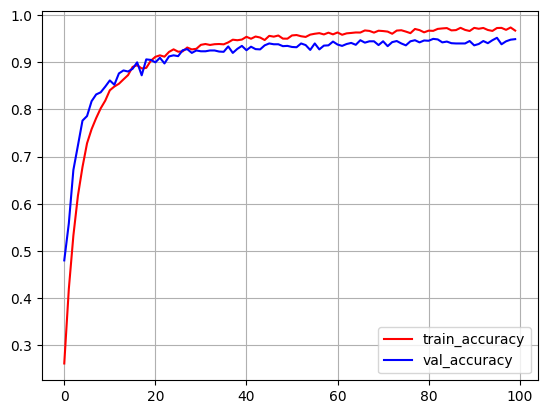

In [37]:
plt.plot(history.history['accuracy'], color = 'red',label = 'train_accuracy' )
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
plt.legend()
plt.grid()
plt.plot()
plt.show()

## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman ; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;"> Graph Between Loss and Val loss </div> 

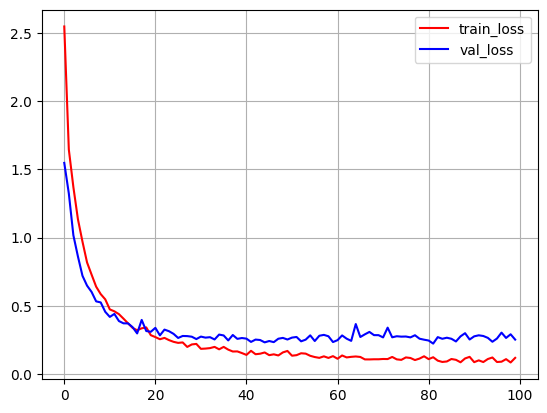

In [38]:
plt.plot(history.history['loss'], color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'val_loss')
plt.legend()
plt.grid()
plt.plot()
plt.show()

In [39]:
test_accuracy=model1.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.949055552482605


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman ; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;"> Prediction on test data </div> 

In [40]:
#model.predict_classes(X_test)
predict_x=model1.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[5 2 5 ... 3 6 7]


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman ; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;"> Prediction on random data </div> 

In [41]:
filename="/kaggle/input/urbansound8k/fold7/157940-9-0-4.wav"
#preprocess the audio file
audio, sample_rate = librosa.load(filename) 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=64)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

#Reshape MFCC feature to 2-D array
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)

#predicted_label=model.predict_classes(mfccs_scaled_features)
x_predict=model1.predict(mfccs_scaled_features) 
predicted_label=np.argmax(x_predict,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
print(prediction_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
[9]
['street_music']
